To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

**Read our [blog post](https://unsloth.ai/blog/r1-reasoning) for guidance to train reasoning model.** GRPO notebook is inspired by [@shxf0072](https://x.com/shxf0072/status/1886085377146180091), [@Teknium1](https://x.com/Teknium1/status/1885077369142337550), [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb)

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
# Normally using pip install unsloth is enough

# Temporarily as of Jan 31st 2025, Colab has some issues with Pytorch
# Using pip install unsloth will take 3 minutes, whilst the below takes <1 minute:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

### Unsloth

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

NotImplementedError: Unsloth: No NVIDIA GPU found? Unsloth currently only supports GPUs!

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("SUPERAGI/GUIDE", split="train")

Resolving data files:   0%|          | 0/33 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/33 [00:00<?, ?it/s]

train-00000-of-00033.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00033.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

train-00002-of-00033.parquet:   0%|          | 0.00/272M [00:00<?, ?B/s]

train-00003-of-00033.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

train-00004-of-00033.parquet:   0%|          | 0.00/572M [00:00<?, ?B/s]

train-00005-of-00033.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

train-00006-of-00033.parquet:   0%|          | 0.00/177M [00:00<?, ?B/s]

train-00007-of-00033.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

train-00008-of-00033.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

train-00009-of-00033.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00010-of-00033.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

train-00011-of-00033.parquet:   0%|          | 0.00/179M [00:00<?, ?B/s]

train-00012-of-00033.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

train-00013-of-00033.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

train-00014-of-00033.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

train-00015-of-00033.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

train-00016-of-00033.parquet:   0%|          | 0.00/179M [00:00<?, ?B/s]

train-00017-of-00033.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00018-of-00033.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

train-00019-of-00033.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

train-00020-of-00033.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

train-00021-of-00033.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

train-00022-of-00033.parquet:   0%|          | 0.00/148M [00:00<?, ?B/s]

train-00023-of-00033.parquet:   0%|          | 0.00/149M [00:00<?, ?B/s]

train-00024-of-00033.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

train-00025-of-00033.parquet:   0%|          | 0.00/660M [00:00<?, ?B/s]

train-00026-of-00033.parquet:   0%|          | 0.00/891M [00:00<?, ?B/s]

train-00027-of-00033.parquet:   0%|          | 0.00/930M [00:00<?, ?B/s]

train-00028-of-00033.parquet:   0%|          | 0.00/936M [00:00<?, ?B/s]

train-00029-of-00033.parquet:   0%|          | 0.00/996M [00:00<?, ?B/s]

train-00030-of-00033.parquet:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

train-00031-of-00033.parquet:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

train-00032-of-00033.parquet:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50640 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/31 [00:00<?, ?it/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [ ]:
dataset

Dataset({
    features: ['previousAction', 'previousActionHistory', 'workflow', 'question', 'answer', 'cot', 'image'],
    num_rows: 50
})

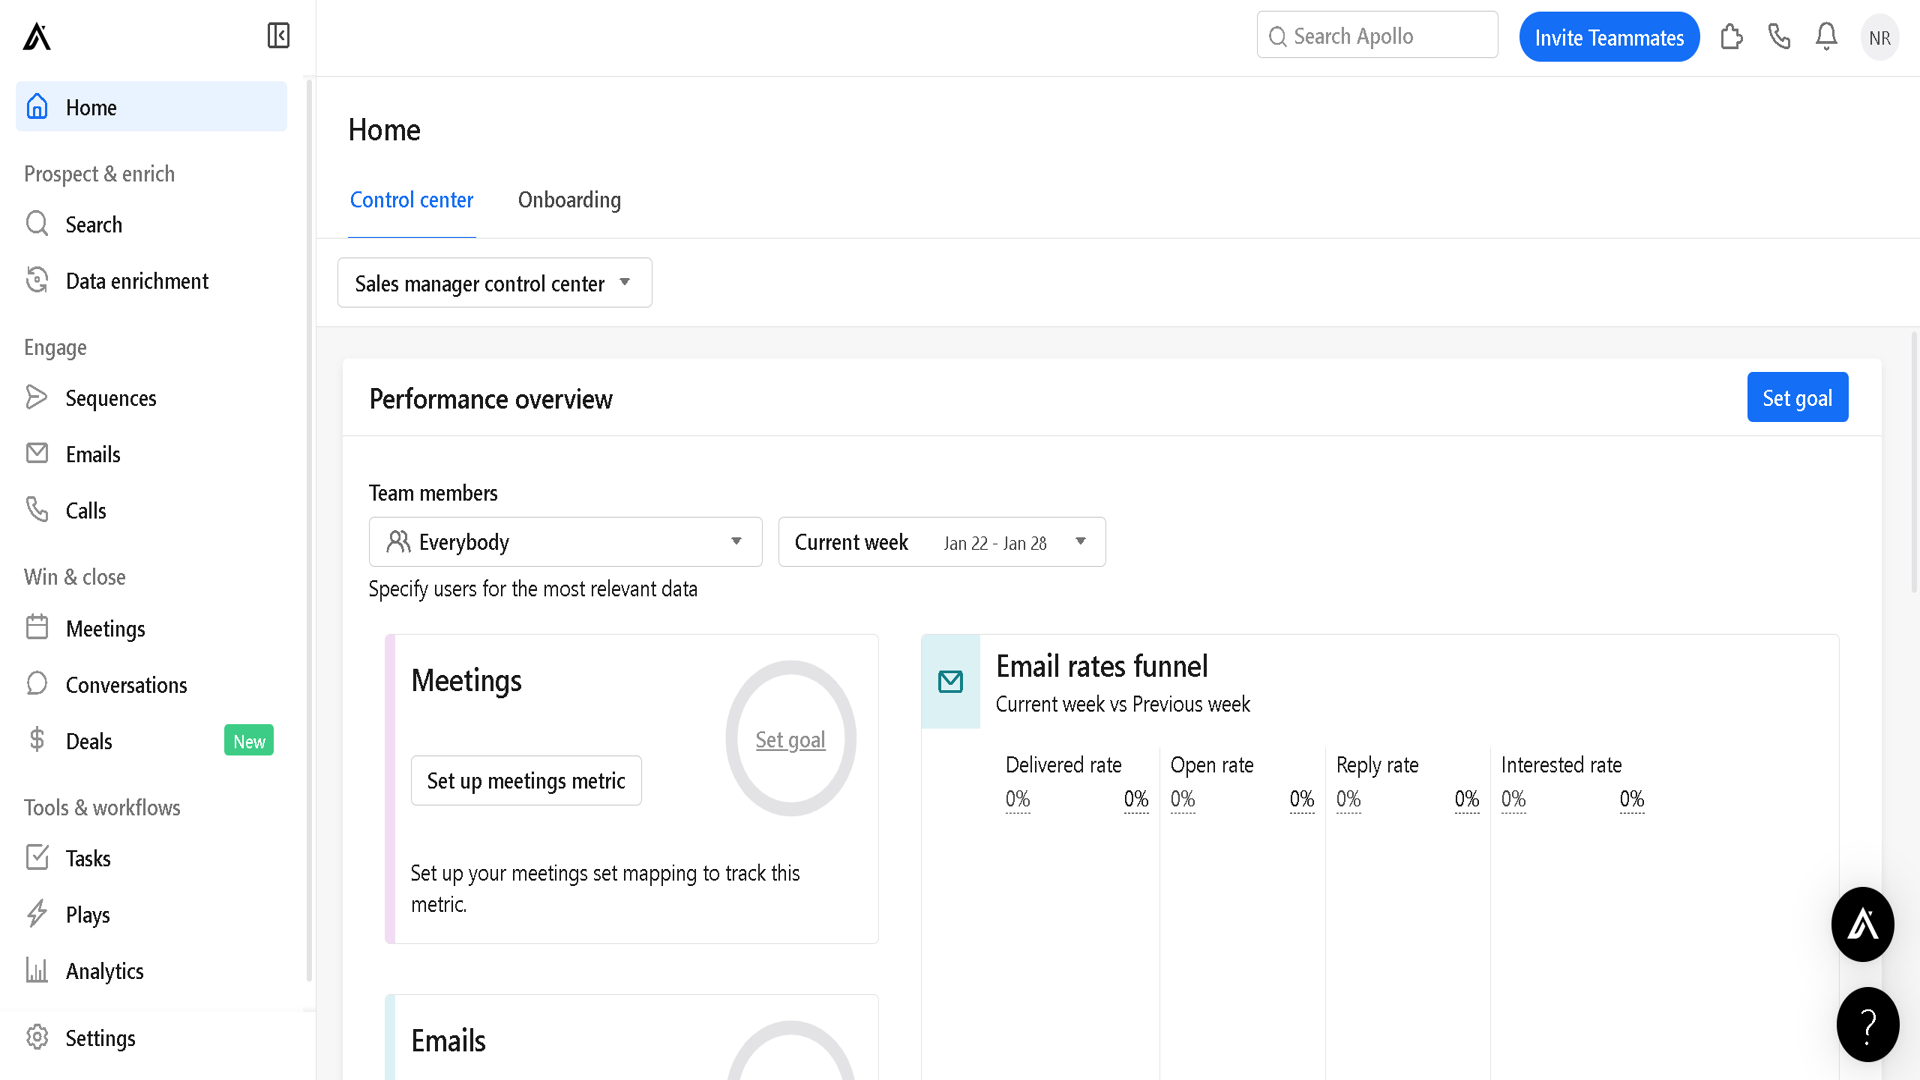

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["caption"]

'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [ ]:
def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : f"{sample['question']} given {sample['previousActionHistory']}"},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : f"{sample['cot'], sample['answer']}"} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Task: Give me the list of all product manager with minimum 5 years of experience working in a series A company with minimum 1M in revenue. given '},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1080>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'CLICK: Click on the Search [0.01,0.189,0.147,0.231] button'}]}]}

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": f"{dataset[0]['question']} given {dataset[0]['previousActionHistory']}"}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

To create a list of product managers with at least 5 years of experience working in a Series A company with minimum 1M in revenue, follow these steps:

1. **Define Your Search Criteria**: Determine the key terms and conditions to filter your search. In this case, you need:

	* Minimum 5 years of experience as a product manager.
	* Series A company.
	* Minimum 1M in revenue.
2. **Use a Job Search Platform**: Platforms like Indeed, Glassdoor, or LinkedIn can help you filter your search based on these criteria. Use these platforms to search for job openings with a focus on


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
8.477 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 52,428,800
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.478200
2,2.671500
3,2.920800
4,2.161300
5,1.930300
6,1.520100
7,2.219000
8,1.191900
9,1.045300
10,0.835600


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

957.9653 seconds used for training.
15.97 minutes used for training.
Peak reserved memory = 10.287 GB.
Peak reserved memory for training = 1.81 GB.
Peak reserved memory % of max memory = 69.752 %.
Peak reserved memory for training % of max memory = 12.273 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": f"{dataset[0]['question']} given {dataset[0]['previousActionHistory']}"}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

CLICK: Click on the Search [0.02,0.273,0.34,0.34] button<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

If you want to finetune Llama-3 2x faster and use 70% less VRAM, go to our [finetuning notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

 Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>
